In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('dark_background')

In [28]:
!pwd

/home/kuba/Projects/ml_project


In [27]:
!ls wikIR1k/training/

BM25.metrics.json  BM25.qrels.csv  BM25.res  qrels  queries.csv


In [3]:
!head wikIR1k/training/queries.csv

id_left,text_left
17783,apulia
6054,isaac newton
13635,u boat
30212,provinces of france
8663,mattel
18449,vandals
15010,the walt disney company
4863,george orwell
349,aol


In [4]:
!wc -l wikIR1k/training/BM25.metrics.json

0 wikIR1k/training/BM25.metrics.json


In [5]:
!head wikIR1k/training/BM25.metrics.json

{"P_5": 0.22164133738601574, "P_10": 0.17428571428571302, "P_20": 0.12799392097264375, "ndcg_cut_5": 0.26061449994418684, "ndcg_cut_10": 0.24561694742388185, "ndcg_cut_20": 0.2519854508215273, "ndcg_cut_100": 0.28861192661304225, "map": 0.1337089125785199, "recall_100": 0.32546280449193543}

In [6]:
!head wikIR1k/training/BM25.qrels.csv

,id_left,id_right,label
0,17783,77063,0
1,17783,17774,0
2,17783,17783,2
3,17783,20576,0
4,17783,77066,0
5,17783,35888,1
6,17783,77064,0
7,17783,97038,1
8,17783,29547,0


In [7]:
!head wikIR1k/training/qrels

17783	0	17783	2
17783	0	17784	1
17783	0	17846	1
17783	0	17994	1
17783	0	17997	1
17783	0	18747	1
17783	0	21972	1
17783	0	35888	1
17783	0	37702	1
17783	0	76737	1


## Documents

In [8]:
documents_df = pd.read_csv('wikIR1k/documents.csv', index_col='id_right')

In [9]:
documents_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99987 entries, 0 to 99999
Data columns (total 1 columns):
text_right    99987 non-null object
dtypes: object(1)
memory usage: 1.5+ MB


In [10]:
documents_df.head()

,text_right
id_right,
0,these institutions are often described as stat...
1,parents usually notice signs during the first ...
2,a planet like earth it is dimensionless and me...
3,it is similar to the ancient greek letter alph...
4,it is bordered by tennessee to the north georg...


In [11]:
document_lengths = documents_df['text_right'].apply(lambda s: s.count(' '))

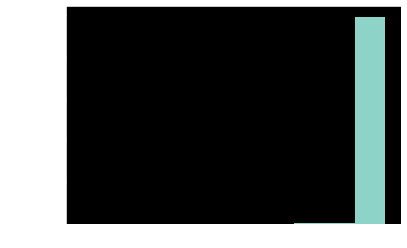

In [12]:
document_lengths.plot.hist();

## Queries

In [13]:
queries_df = pd.read_csv('wikIR1k/training/queries.csv', index_col='id_left')

In [14]:
queries_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1645 entries, 17783 to 12052
Data columns (total 1 columns):
text_left    1645 non-null object
dtypes: object(1)
memory usage: 25.7+ KB


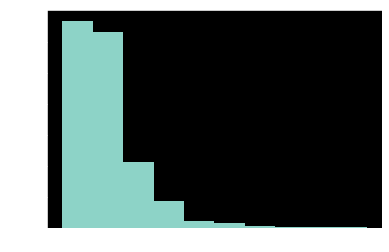

In [15]:
queries_df['text_left'].apply(lambda s: len(s.split())).plot.hist();

# BM25 results

In [16]:
!head wikIR1k/training/BM25.qrels.csv

,id_left,id_right,label
0,17783,77063,0
1,17783,17774,0
2,17783,17783,2
3,17783,20576,0
4,17783,77066,0
5,17783,35888,1
6,17783,77064,0
7,17783,97038,1
8,17783,29547,0


In [17]:
import rank_bm25

In [18]:
documents_df['text_right']

id_right
0        these institutions are often described as stat...
1        parents usually notice signs during the first ...
2        a planet like earth it is dimensionless and me...
3        it is similar to the ancient greek letter alph...
4        it is bordered by tennessee to the north georg...
                               ...                        
99995    he was the first born son of constantine i and...
99996    they were the 2003 2006 and 2008 wnba champion...
99997    36 and dewitt clinton high school in the bronx...
99998    he was a republican politician who served as t...
99999    exterior arcades are designed to provide a she...
Name: text_right, Length: 99987, dtype: object

In [19]:
documents_df['text_right']

id_right
0        these institutions are often described as stat...
1        parents usually notice signs during the first ...
2        a planet like earth it is dimensionless and me...
3        it is similar to the ancient greek letter alph...
4        it is bordered by tennessee to the north georg...
                               ...                        
99995    he was the first born son of constantine i and...
99996    they were the 2003 2006 and 2008 wnba champion...
99997    36 and dewitt clinton high school in the bronx...
99998    he was a republican politician who served as t...
99999    exterior arcades are designed to provide a she...
Name: text_right, Length: 99987, dtype: object

In [20]:
import nltk
from nltk import stem
import tqdm 
from mlutil.parallel import mapp
from toolz import partial


stop_words = set(nltk.corpus.stopwords.words('english'))


def get_document_stems(doc_with_key, stemmer):
    key, value = doc_with_key
    value = value['text_right']
    stems = [stemmer.stem(elem) for elem in value.split(" ") if elem not in stop_words]
    return key, stems 


def make_bm25(documents, stemmer=stem.PorterStemmer()):
    docs_dict = dict(mapp(partial(get_document_stems, stemmer=stemmer), documents.iterrows()))
    return rank_bm25.BM25Okapi(docs_dict.values())

/etc/miniconda/envs/ml/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)
W0109 23:22:03.829391 139994100246336 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [22]:
%%time
bm25 = make_bm25(documents_df)

CPU times: user 51.5 s, sys: 4.26 s, total: 55.8 s
Wall time: 1min 1s


In [23]:
query = queries_df['text_left'].iloc[20].split()
sorted_indices = np.argsort(-bm25.get_scores(query))
print(query)

['anatolia']


In [24]:
stem.PorterStemmer().stem('anatolia')

'anatolia'

In [25]:
list(documents_df.iloc[sorted_indices[:5]].iterrows())

[(124, text_right    it makes up the majority of modern day turkey ...
  Name: 124, dtype: object),
 (12849, text_right    the geographic coordinates of the country lie ...
  Name: 12849, dtype: object),
 (39746, text_right    urban called for a military expedition to aid ...
  Name: 39746, dtype: object),
 (73482, text_right    the decisive defeat of the byzantine army and ...
  Name: 73482, dtype: object),
 (9490, text_right    reliable information about the early history o...
  Name: 9490, dtype: object)]